In [ ]:
# !pip -q install torchmetrics

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")
device

device(type='mps')

In [ ]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std, inplace=True)
])

In [ ]:
train_dataset = datasets.CIFAR10(root="data",
                 download=True,
                 train=True,
                 transform=transform)

test_dataset = datasets.CIFAR10(root="data",
                 download=True,
                 train=False,
                 transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
img, label = train_dataset[0]
img.shape, label

(torch.Size([3, 32, 32]), 6)

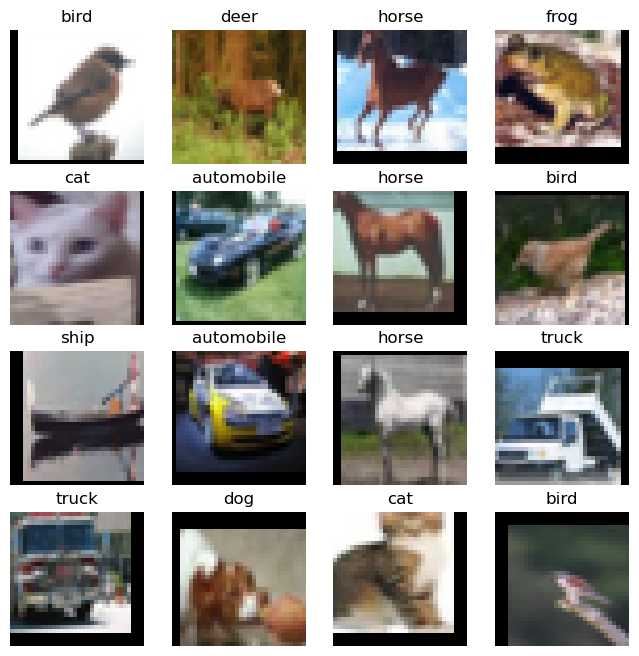

In [ ]:
def denormalize(img):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

def plot_random_samples(dataset, n_rows=4, n_cols=4):
  n_samples = n_rows * n_cols
  sample_indices = np.random.choice(len(dataset), n_samples)

  imgs, labels = zip(*[dataset[i] for i in sample_indices])

  plt.figure(figsize=(8, 8))

  for i in range(n_samples):
    img = denormalize(imgs[i])

    plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.title(dataset.classes[labels[i]])
    plt.axis(False)

plot_random_samples(train_dataset)

In [ ]:
def to_device(*args, device=device):
  return [arg.to(device, non_blocking=True) for arg in args]

def train_epoch(dataloader, model, criterion, optimizer, accuracy):
  model.train()

  train_loss, train_acc = 0, 0

  for X, y in tqdm(dataloader, desc="Training", leave=False):
    X, y = to_device(X, y)

    logits = model(X)

    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      train_loss += loss.cpu().item()
      train_acc += accuracy(preds, y).cpu().item()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def validate_epoch(dataloader, model, criterion, accuracy):
  model.eval()

  val_loss, val_acc = 0, 0

  with torch.no_grad():
    for X, y in tqdm(dataloader, desc="Validate", leave=False):
      X, y = to_device(X, y)

      logits = model(X)
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      loss = criterion(logits, y)

      val_loss += loss.cpu().item()
      val_acc += accuracy(preds, y).cpu().item()

  val_loss /= len(dataloader)
  val_acc /= len(dataloader)

  return val_loss, val_acc

In [ ]:
def train(n_epochs=100,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          scheduler=None,
          accuracy=accuracy):

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in tqdm(range(1, n_epochs + 1), desc="Epoch", leave=False):
      train_loss, train_acc = train_epoch(train_dataloader, model, criterion, optimizer, accuracy)
      val_loss, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

      if scheduler is not None:
        scheduler.step(val_acc)

      train_losses.append(train_loss)
      train_accs.append(train_acc)
      val_losses.append(val_loss)
      val_accs.append(val_acc)

      print(f"Epoch: {epoch: 4d} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .5f} | Val loss: {val_loss: .5f} | Val acc: {val_acc: .5f}")

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
def plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs):
    epochs = np.arange(1, n_epochs + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="train loss")
    plt.plot(epochs, val_losses, label="val loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="train acc")
    plt.plot(epochs, val_accs, label="val acc")
    plt.title("Acc")
    plt.legend()

## TinyVGGCIFAR10_v0

In [ ]:
class TinyVGGCIFAR10_v0(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

In [ ]:
model = TinyVGGCIFAR10_v0().to(device)

with torch.no_grad():
  X, y = next(iter(train_dataloader))
  X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
  print(f"input  shape: {X.shape}")

  logits = model(X)
  print(f"logits shape: {logits.shape}")

  probs = torch.softmax(logits, dim=1)
  print(f"probs  shape: {probs.shape}")

  preds = probs.argmax(dim=1)
  print(f"preds  shape: {preds.shape}")

model

input  shape: torch.Size([32, 3, 32, 32])
logits shape: torch.Size([32, 10])
probs  shape: torch.Size([32, 10])
preds  shape: torch.Size([32])


TinyVGGCIFAR10_v0(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=256, out_featur

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  1.78896 | Train acc:  0.33385 | Val loss:  1.40153 | Val acc:  0.49451


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.30319 | Train acc:  0.53541 | Val loss:  1.07741 | Val acc:  0.62200


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.13034 | Train acc:  0.60499 | Val loss:  1.01492 | Val acc:  0.64077


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  1.02489 | Train acc:  0.64461 | Val loss:  0.93488 | Val acc:  0.67502


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  0.95724 | Train acc:  0.67001 | Val loss:  0.90385 | Val acc:  0.68421


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  0.91422 | Train acc:  0.68820 | Val loss:  0.88825 | Val acc:  0.68990


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  0.88166 | Train acc:  0.69886 | Val loss:  0.90265 | Val acc:  0.69129


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  0.85393 | Train acc:  0.70859 | Val loss:  0.85351 | Val acc:  0.70248


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  0.83515 | Train acc:  0.71651 | Val loss:  0.86303 | Val acc:  0.70687


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  0.83198 | Train acc:  0.71821 | Val loss:  0.94648 | Val acc:  0.67592


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   11 | Train loss:  0.82566 | Train acc:  0.72311 | Val loss:  0.86101 | Val acc:  0.70457


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   12 | Train loss:  0.81865 | Train acc:  0.72659 | Val loss:  0.84271 | Val acc:  0.71655


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   13 | Train loss:  0.82367 | Train acc:  0.72465 | Val loss:  0.89730 | Val acc:  0.70108


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   14 | Train loss:  0.82794 | Train acc:  0.72575 | Val loss:  0.88932 | Val acc:  0.70108


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   15 | Train loss:  0.82504 | Train acc:  0.72575 | Val loss:  0.88636 | Val acc:  0.70308


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   16 | Train loss:  0.84027 | Train acc:  0.72333 | Val loss:  0.94898 | Val acc:  0.68680


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   17 | Train loss:  0.84968 | Train acc:  0.72197 | Val loss:  0.93027 | Val acc:  0.68970


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   18 | Train loss:  0.84464 | Train acc:  0.72383 | Val loss:  0.93624 | Val acc:  0.68670


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   19 | Train loss:  0.86849 | Train acc:  0.71927 | Val loss:  0.98723 | Val acc:  0.67841


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   20 | Train loss:  0.86772 | Train acc:  0.71889 | Val loss:  0.91870 | Val acc:  0.69798


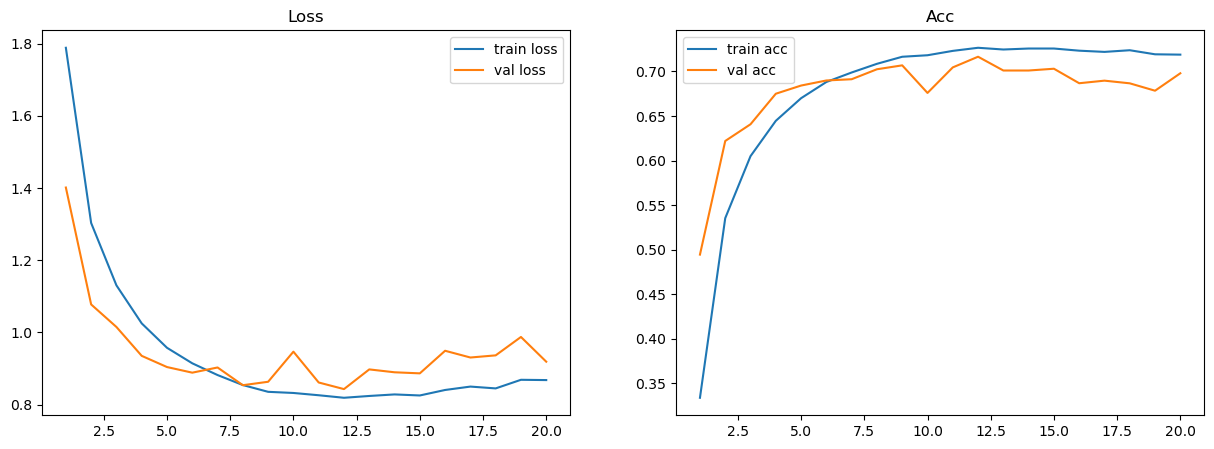

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v0().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=10e-3)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 20
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

### 증상
- 초기 10 epoch 부근까지 빠르게 학습, Train/Val Accuracy 모두 0.7 도달
- 이후로는 Train/Val Accuracy 정체
- Train Accuracy 상승 또는 유지, Val Accuracy 하락 -> 오버피팅 패턴

### 원인 분석
- **features layer에 비해 너무 많은 classifier layer의 파라미터 수** \
  Dropout 적용해도 오버피팅 발생한 건, 충분히 regularization 적용되지 못했다는 뜻
- **너무 작은 초기 learning rate (= 0.01)** \
  급격한 성능 변화 flatten은 불안정한 lr 스케줄링 의심
- **Data augumentation 안함** \
  CIFAR-10은 크기가 작은 이미지, 증강 안하면 오버피팅 발생하기 쉬움

### 개선
- classifier layer (Fully connected) 축소
- Conv -> BatchNorm -> ReLU 도입
- Data augumentation
- learning rate 조정 또는 스케줄링 도입

In [ ]:
sum(p.numel() for p in model.features.parameters())

16656

In [ ]:
sum(p.numel() for p in model.classifier.parameters())

592906

## TinyVGGCIFAR10_v1_reduced

In [ ]:
class TinyVGGCIFAR10_v1_reduced(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(128, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  0.84099 | Train acc:  0.71575 | Val loss:  0.90218 | Val acc:  0.69509


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  0.83350 | Train acc:  0.71649 | Val loss:  0.89291 | Val acc:  0.69339


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  0.83038 | Train acc:  0.72025 | Val loss:  0.91449 | Val acc:  0.68990


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  0.83440 | Train acc:  0.72289 | Val loss:  0.94376 | Val acc:  0.68470


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  0.84930 | Train acc:  0.71739 | Val loss:  0.91896 | Val acc:  0.69239


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  0.83230 | Train acc:  0.72555 | Val loss:  0.89763 | Val acc:  0.70767


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  0.84795 | Train acc:  0.71981 | Val loss:  0.88934 | Val acc:  0.70038


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  0.83444 | Train acc:  0.72601 | Val loss:  0.92693 | Val acc:  0.69129


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  0.85772 | Train acc:  0.72061 | Val loss:  0.95567 | Val acc:  0.68421


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  0.85139 | Train acc:  0.72183 | Val loss:  0.92629 | Val acc:  0.68800


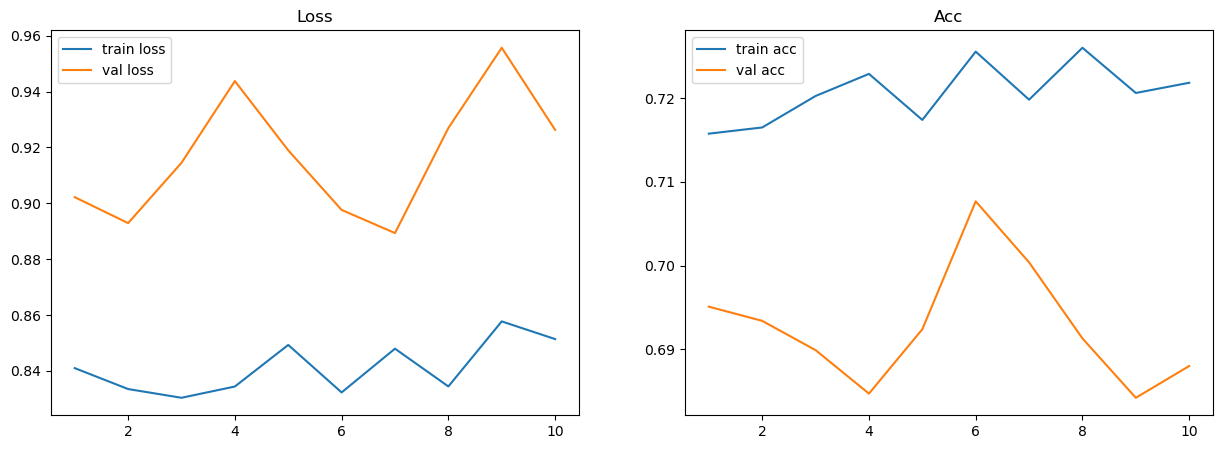

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v1_reduced().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=10e-3)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

## TinyVGGCIFAR10_v1_bn

In [ ]:
class TinyVGGCIFAR10_v1_bn(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  0.84592 | Train acc:  0.72465 | Val loss:  0.93361 | Val acc:  0.68820


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  0.88587 | Train acc:  0.71037 | Val loss:  0.91502 | Val acc:  0.70547


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  0.88332 | Train acc:  0.71749 | Val loss:  0.97757 | Val acc:  0.68490


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  0.89276 | Train acc:  0.71297 | Val loss:  0.99282 | Val acc:  0.66963


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  0.90510 | Train acc:  0.70885 | Val loss:  0.94780 | Val acc:  0.69339


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  0.91333 | Train acc:  0.70777 | Val loss:  0.95527 | Val acc:  0.68810


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  0.91874 | Train acc:  0.70699 | Val loss:  0.98029 | Val acc:  0.68480


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  0.96891 | Train acc:  0.69526 | Val loss:  1.05167 | Val acc:  0.65695


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  0.96995 | Train acc:  0.69542 | Val loss:  1.02832 | Val acc:  0.66563


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  0.97652 | Train acc:  0.69414 | Val loss:  1.04877 | Val acc:  0.66314


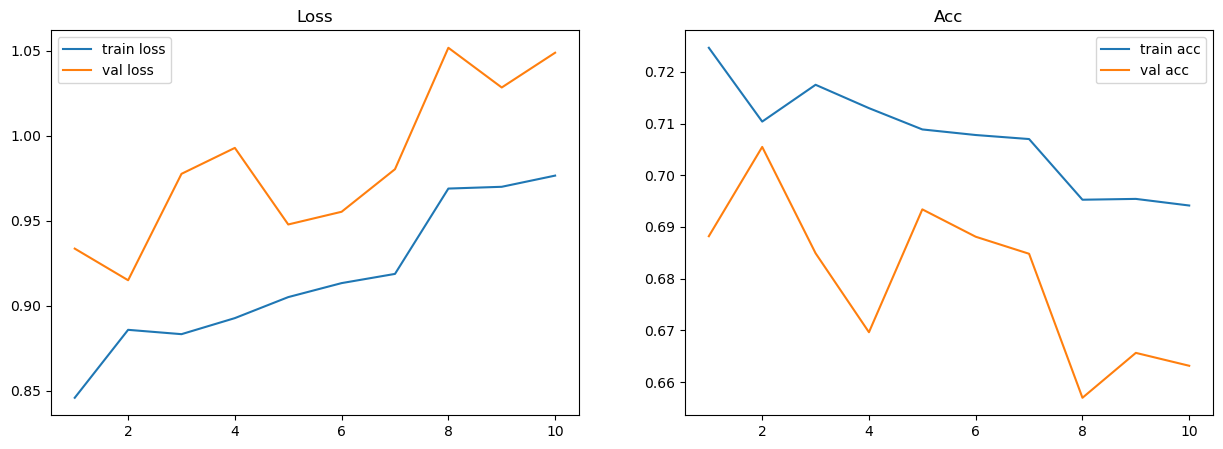

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v1_bn().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=10e-3)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

## TinyVGGCIFAR10_v1_reduced_bn

In [ ]:
class TinyVGGCIFAR10_v1_reduced_bn(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(128, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  0.96381 | Train acc:  0.69918 | Val loss:  0.99806 | Val acc:  0.68341


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.01922 | Train acc:  0.68350 | Val loss:  1.06588 | Val acc:  0.66074


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.00181 | Train acc:  0.68846 | Val loss:  1.02492 | Val acc:  0.66953


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  1.03013 | Train acc:  0.67636 | Val loss:  1.12470 | Val acc:  0.64517


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  1.03715 | Train acc:  0.67544 | Val loss:  1.13176 | Val acc:  0.65385


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  1.04751 | Train acc:  0.67448 | Val loss:  1.13680 | Val acc:  0.63988


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  1.04132 | Train acc:  0.67674 | Val loss:  1.09588 | Val acc:  0.66583


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  1.07414 | Train acc:  0.67079 | Val loss:  1.12439 | Val acc:  0.63339


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  1.10535 | Train acc:  0.65777 | Val loss:  1.07020 | Val acc:  0.66234


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  1.08932 | Train acc:  0.66519 | Val loss:  1.07063 | Val acc:  0.67362


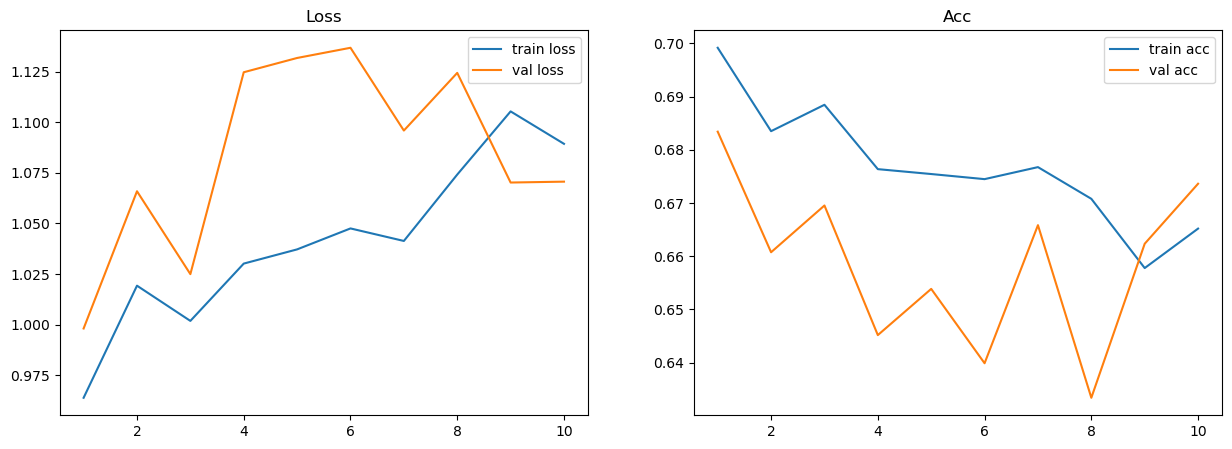

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v1_reduced_bn().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.1)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

In [ ]:
class TinyVGGCIFAR10_v1_reduced_bn_2(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024, 10)
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

In [ ]:
model = TinyVGGCIFAR10_v1_reduced_bn_2()

sum(p.numel() for p in model.features.parameters()), sum(p.numel() for p in model.classifier.parameters())

(4392, 10250)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  1.13780 | Train acc:  0.65137 | Val loss:  1.09303 | Val acc:  0.66394


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.15398 | Train acc:  0.64475 | Val loss:  1.10899 | Val acc:  0.64776


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.15963 | Train acc:  0.64443 | Val loss:  1.22572 | Val acc:  0.61971


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  1.17033 | Train acc:  0.64109 | Val loss:  1.18228 | Val acc:  0.62500


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  1.21707 | Train acc:  0.62542 | Val loss:  1.24921 | Val acc:  0.61322


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  1.23320 | Train acc:  0.62222 | Val loss:  1.21498 | Val acc:  0.61412


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  1.23897 | Train acc:  0.62440 | Val loss:  1.27073 | Val acc:  0.59904


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  1.21117 | Train acc:  0.62770 | Val loss:  1.20426 | Val acc:  0.62660


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  1.22340 | Train acc:  0.62748 | Val loss:  1.18249 | Val acc:  0.63249


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  1.26416 | Train acc:  0.61342 | Val loss:  1.18927 | Val acc:  0.63079


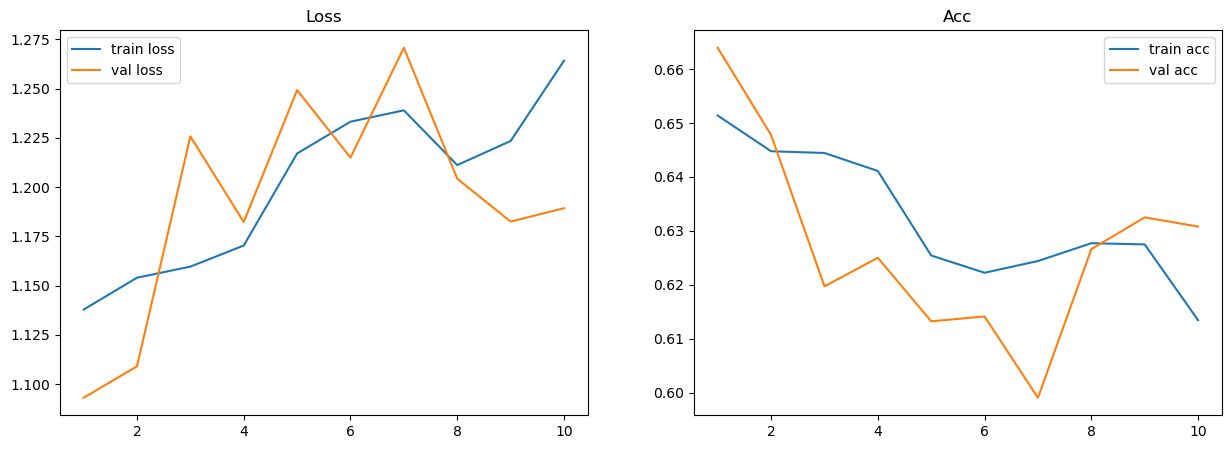

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v1_reduced_bn_2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.1)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

## TinyVGGCIFAR10_v2

In [ ]:
class TinyVGGCIFAR10_v2(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  1.28399 | Train acc:  0.60387 | Val loss:  1.23200 | Val acc:  0.60893


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.28468 | Train acc:  0.60555 | Val loss:  1.28508 | Val acc:  0.59734


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.26188 | Train acc:  0.61496 | Val loss:  1.26226 | Val acc:  0.61741


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  1.30341 | Train acc:  0.60049 | Val loss:  1.26043 | Val acc:  0.60553


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  1.31240 | Train acc:  0.59227 | Val loss:  1.23035 | Val acc:  0.61701


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  1.37879 | Train acc:  0.57448 | Val loss:  1.34516 | Val acc:  0.55911


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  1.37192 | Train acc:  0.57294 | Val loss:  1.23782 | Val acc:  0.61861


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  1.38066 | Train acc:  0.57342 | Val loss:  1.18299 | Val acc:  0.62819


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  1.41667 | Train acc:  0.55800 | Val loss:  1.36881 | Val acc:  0.56290


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  1.42818 | Train acc:  0.55528 | Val loss:  1.35899 | Val acc:  0.57099


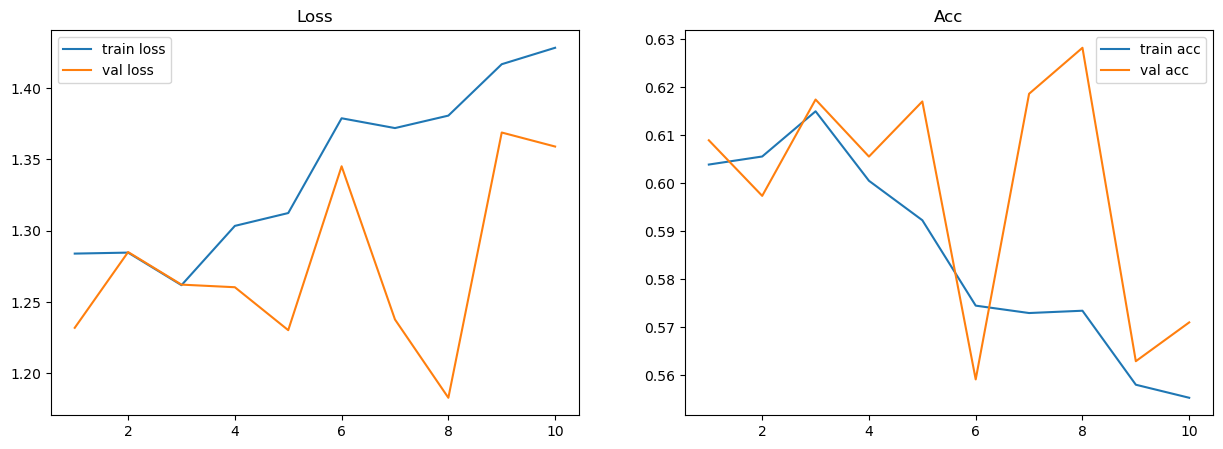

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v2().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

## TinyVGGCIFAR10_v2_ch

In [ ]:
class TinyVGGCIFAR10_v2_ch(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  1.38680 | Train acc:  0.57184 | Val loss:  1.30112 | Val acc:  0.59036


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.43748 | Train acc:  0.55454 | Val loss:  1.35554 | Val acc:  0.57348


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.47235 | Train acc:  0.53919 | Val loss:  1.52547 | Val acc:  0.49032


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  1.51167 | Train acc:  0.52537 | Val loss:  1.56545 | Val acc:  0.49191


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  1.50488 | Train acc:  0.53065 | Val loss:  1.40366 | Val acc:  0.56619


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  1.48610 | Train acc:  0.53565 | Val loss:  1.36129 | Val acc:  0.56400


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  1.46605 | Train acc:  0.54179 | Val loss:  1.33379 | Val acc:  0.58197


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  1.53170 | Train acc:  0.52005 | Val loss:  1.37724 | Val acc:  0.56350


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  1.51382 | Train acc:  0.52615 | Val loss:  1.42268 | Val acc:  0.54922


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  1.54774 | Train acc:  0.51142 | Val loss:  1.52070 | Val acc:  0.50719


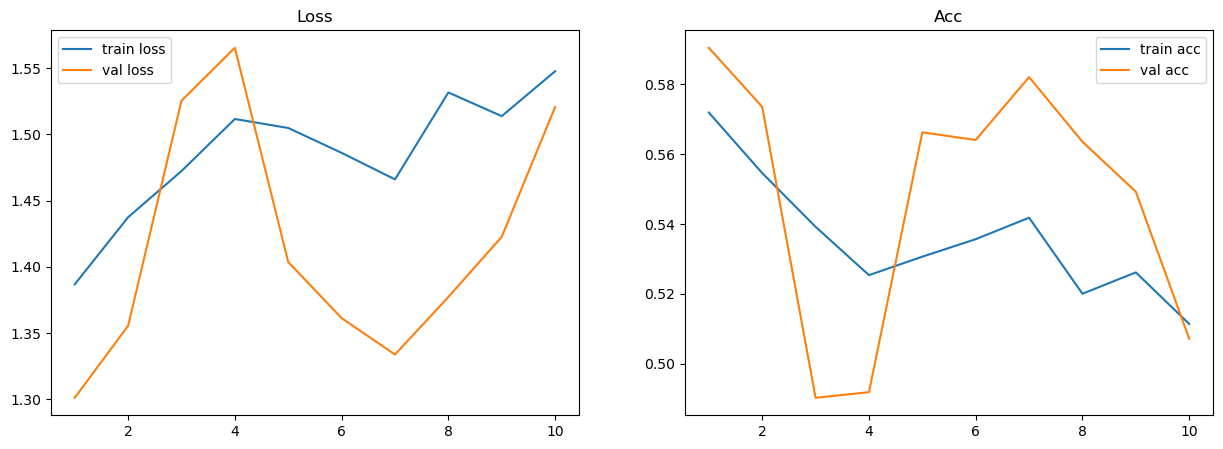

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v2_ch().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

In [ ]:
model = TinyVGGCIFAR10_v1_reduced_bn_2()

sum(p.numel() for p in model.features.parameters()), sum(p.numel() for p in model.classifier.parameters())

(4392, 10250)

## TinyVGGCIFAR10_v3

테스트하기 수월하도록 `VGGBlock(nn.Module)` 도입해 모듈화된 코드로 리팩토링.

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_convs, batch_norm=True):
        super().__init__()

        layers = []

        for _ in range(n_convs):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
class VGG11CIFAR10(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            VGGBlock(3, 64, n_convs=1),
            VGGBlock(64, 128, n_convs=1),
            VGGBlock(128, 256, n_convs=2),
            VGGBlock(256, 512, n_convs=2),
            VGGBlock(512, 512, n_convs=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = VGG11CIFAR10().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

NotImplementedError: Module [TinyVGGCIFAR10_v3] is missing the required "forward" function

In [ ]:
sum(p.numel() for p in model.features.parameters()), sum(p.numel() for p in model.classifier.parameters())

(9225984, 33603594)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    1 | Train loss:  1.84825 | Train acc:  0.35077 | Val loss:  1.67835 | Val acc:  0.41154


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    2 | Train loss:  1.81427 | Train acc:  0.35521 | Val loss:  1.78401 | Val acc:  0.35084


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    3 | Train loss:  1.81542 | Train acc:  0.35976 | Val loss:  1.74114 | Val acc:  0.38998


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    4 | Train loss:  1.80955 | Train acc:  0.36268 | Val loss:  1.76940 | Val acc:  0.39048


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    5 | Train loss:  1.79764 | Train acc:  0.36874 | Val loss:  1.76090 | Val acc:  0.37121


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    6 | Train loss:  1.80186 | Train acc:  0.36880 | Val loss:  1.68463 | Val acc:  0.40925


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    7 | Train loss:  1.79734 | Train acc:  0.37070 | Val loss:  1.81816 | Val acc:  0.35074


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    8 | Train loss:  1.78615 | Train acc:  0.37708 | Val loss:  1.70644 | Val acc:  0.40565


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:    9 | Train loss:  1.80568 | Train acc:  0.36166 | Val loss:  1.76642 | Val acc:  0.36362


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Validate:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   10 | Train loss:  1.78339 | Train acc:  0.37504 | Val loss:  1.71065 | Val acc:  0.39926


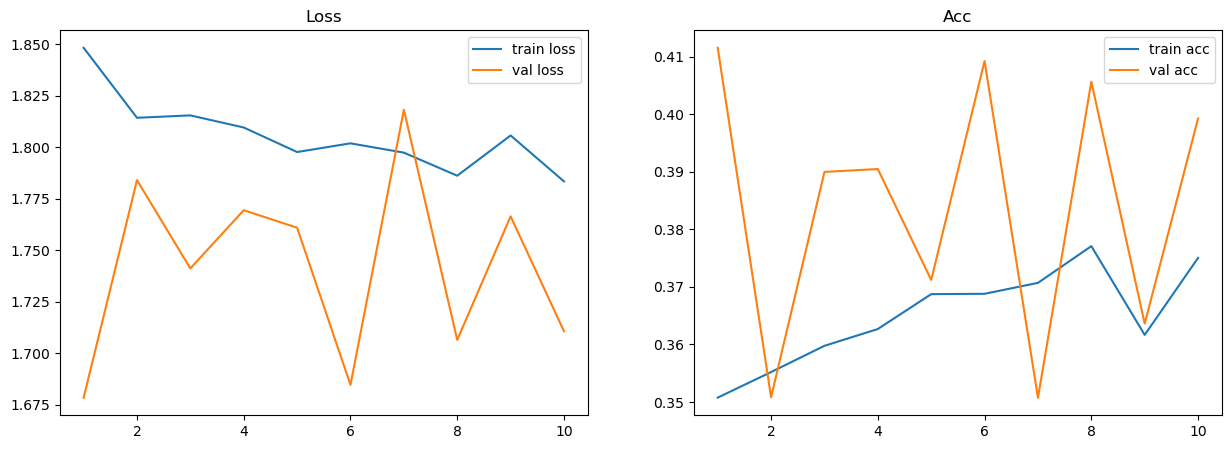

In [ ]:
n_epochs = 10
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

In [ ]:
class TinyVGGCIFAR10_v3(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out

In [ ]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGGCIFAR10_v3().to(device)

criterion = nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          momentum=0.9,
                          lr=10e-3)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 20
train_losses, train_accs, val_losses, val_accs = train(n_epochs=n_epochs)

plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/196 [00:00<?, ?it/s]

NotImplementedError: Module [TinyVGGCIFAR10_v3] is missing the required "forward" function

In [ ]:
model

TinyVGGCIFAR10_v3(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=256, out_featur

## ‼️ 기본 인자는 함수 정의 시점에 한 번만 평가된다

Python의 함수는 def가 실행되는 시점에 객체로 만들어진다.

이때 모든 기본 인자는 미리 평가되어서 해당 값이 함수 객체의 __defaults__라는 속성에 저장된다.

그래서 func()처럼 인자를 생략하고 호출하면 __defaults__에 저장된 값을 그대로 사용하게 되는 것.

In [ ]:
m = "This is a message"

In [ ]:
def func(msg=m):
    print(msg)

In [ ]:
func()

This is a message


In [ ]:
m = "This is a new message"

In [ ]:
func()

This is a message
